In [9]:
import numpy as np
import math
from spatialmath import SE3
from spatialmath.base import e2h,h2e
from roboticstoolbox import *
%matplotlib widget

In [10]:
#相机DH
DFbot1 = DHRobot(
    [
        RevoluteMDH(d=0.04145,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteMDH(alpha=-np.pi/2,qlim=np.array([0,np.pi])),
        RevoluteMDH(a=0.05,d=0.06,qlim=np.array([-np.pi,np.pi]))
    ],
    name = "DFbot",
)

In [11]:
#夹爪DH
DFbot2 = DHRobot(
    [
        RevoluteDH(d=0.04145,alpha=np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(a=-0.08285,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(alpha=-np.pi/2,qlim=np.array([-np.pi,np.pi])),
        RevoluteDH(d=0.11,qlim=np.array([-np.pi,3/2*np.pi]))
    ],
    name = "DFbot",
)

   0        -1         0         0         
  -0.866     0        -0.5      -0.2168    
   0.5       0        -0.866     0.09734   
   0         0         0         1         



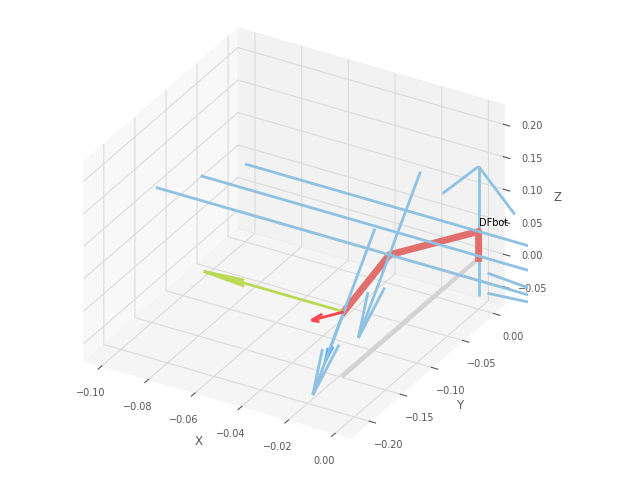

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [12]:
T1 = DFbot1.fkine([np.pi/2,-np.pi/6,0,np.pi,0,0])
print(T1)
DFbot1.plot([np.pi/2,-np.pi/6,0,np.pi,0,0])

In [13]:
mtx = np.array([[913.08825216,   0.        , 327.50021778],
       [  0.        , 917.24582554, 228.7678789 ],
       [  0.        ,   0.        ,   1.        ]])

In [20]:
#内参矩阵
K = mtx

#外参矩阵
pose = T1
extrinsic = np.linalg.inv(pose)

#3D点（世界坐标系）
point_3d = np.array([0,-0.28,0,1])

point_camera = extrinsic@point_3d
point_2d = K@point_camera[:3]
depth = point_2d[2]
point_2d /= depth

print("point 2D:",point_2d)

point 2D: [375.26034975 228.7678789    1.        ]


In [17]:
depth

0.115896752986865

In [21]:
#逆过程：已知像素坐标（和深度depth）和机械臂位姿，求解世界坐标
depth = 0.115

xaxis = 375.26034975
yaxis = 228.7678789

375.26034975

In [23]:
point_2d = depth*np.array([xaxis,yaxis,1])
point_camera = e2h(np.linalg.inv(K)@point_2d)
new_point_3d = np.array(np.linalg.inv(extrinsic)@point_camera)
print(new_point_3d)

[[-7.37693729e-18]
 [-2.79511002e-01]
 [ 7.53158019e-04]
 [ 1.00000000e+00]]


In [27]:
#已知世界坐标，进行机械臂抓取

#夹爪初始位姿
T21 = DFbot2.fkine([np.pi/2,-np.pi/6,0,np.pi,0])
T21

   0        -1         0         0         
  -0.866     0        -0.5      -0.1985    
   0.5       0        -0.866     0.02904   
   0         0         0         1         


In [29]:
#T2是夹取位姿，其中旋转矩阵保持不变，位移为摄像头识别的世界坐标
T2 = np.array(T21)
T2[:,-1]=new_point_3d.flatten()
T2

array([[-8.36449319e-17, -1.00000000e+00,  8.36449319e-17,
        -7.37693729e-18],
       [-8.66025404e-01,  3.06161700e-17, -5.00000000e-01,
        -2.79511002e-01],
       [ 5.00000000e-01, -1.14261102e-16, -8.66025404e-01,
         7.53158019e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [34]:
sol = DFbot2.ikine_LM(T2,q0 = [np.pi/2,-np.pi/6,0,np.pi,0], ilimit=500,slimit=500,joint_limits=True,tol=0.01)
sol.q

array([ 1.57079633e+00, -2.13970619e-01, -1.64992746e-03,  2.82866464e+00,
        0.00000000e+00])

In [35]:
sol.q - [np.pi/2,-np.pi/6,0,np.pi,0] #拍摄抓取关节变化

array([ 0.        ,  0.30962816, -0.00164993, -0.31292801,  0.        ])

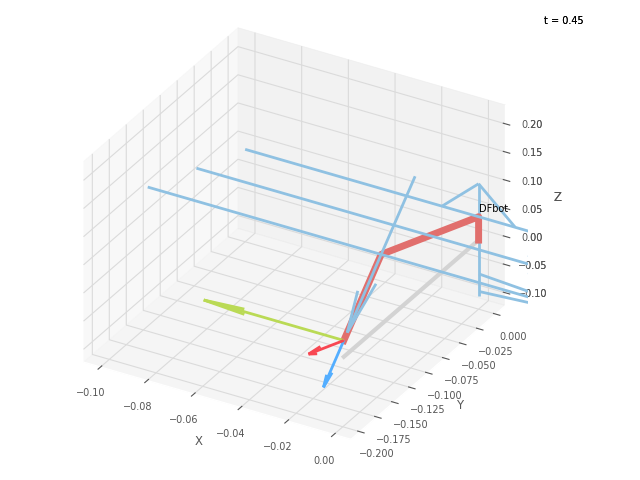

PyPlot3D backend, t = 0.49999999999999994, scene:
  robot: Text(0.0, 0.0, 'DFbot')

In [38]:
qt = jtraj([np.pi/2,-np.pi/6,0,np.pi,0],sol.q,10)
DFbot2.plot(qt.q, backend="pyplot")